# Alpha Research Framework

Мини-фреймворк для исследования кросс-секционных альфа-сигналов.

## Возможности
- Создание альф из цен
- Кросс-секционная нейтрализация
- Нормализация позиций
- Пост-обработка (rank, decay, truncate)
- Бэктест
- Оценка Sharpe, turnover, drawdown
- Корреляции между альфами


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable, List, Optional, Union, Dict


In [2]:
start_df = pd.read_parquet('close.parquet')
start_df

,A,AACG,AAMI,AAOI,AAPL,AAT,ABBV,ABCB,ABEV,ABG,...,YDKG,YELP,YPF,ZBRA,ZEUS,ZG,ZTR,ZTS,ZUMZ,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,37.636368,0.610933,13.572110,16.290001,23.776182,25.803417,38.010921,28.721344,2.925977,66.519997,...,111.400002,27.600000,15.378125,66.489998,10.857997,24.510000,3.647442,43.853802,15.160000,8.385332
2016-01-05,37.506878,0.626278,13.691565,16.080000,23.180365,26.606346,37.852570,28.836063,2.967090,65.129997,...,111.199997,26.620001,15.309993,64.820000,10.793200,24.040001,3.650455,44.540329,15.310000,8.110702
2016-01-06,37.673359,0.689578,13.204547,16.049999,22.726725,26.578897,37.859173,28.359577,2.932829,57.340000,...,111.599998,25.910000,14.580019,62.230000,10.793200,23.879999,3.617325,44.549610,15.080000,7.781149
2016-01-07,36.073189,0.609015,12.497002,15.290000,21.767565,26.009302,37.747002,27.830154,2.816338,55.619999,...,110.400002,25.270000,14.346428,59.410000,10.173012,23.020000,3.575158,43.195118,16.809999,7.414975
2016-01-08,35.693962,0.565856,12.552132,14.790000,21.882662,25.775970,36.717712,27.556606,2.864304,53.340000,...,110.400002,25.049999,14.258830,59.250000,9.839771,23.889999,3.566123,42.564262,16.620001,7.181542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,154.316727,1.180000,25.851524,5.590000,176.796082,29.805992,115.908318,47.185169,2.272167,167.490005,...,7.800000,37.209999,4.070000,606.330017,21.783871,60.990002,5.924202,237.800217,47.770000,35.209629
2021-12-28,154.744476,1.170000,25.623016,5.480000,175.776443,29.684269,115.891083,47.488670,2.263875,169.520004,...,6.640000,36.900002,4.070000,597.320007,21.641058,60.000000,5.924202,235.620087,47.570000,35.393059
2021-12-29,156.173523,1.060000,25.473984,5.300000,175.864685,29.830334,116.727570,47.659389,2.247290,169.000000,...,6.200000,36.509998,3.990000,601.119995,22.079018,59.209999,5.942968,238.301834,48.130001,35.460644


In [3]:
class AlphaStrategy:
    def __init__(self):
        """Инициализация стратегии без данных"""
        self.original_alpha = None
        self.manipulations = []
        self.final_alpha = None
        self.prices_df = None
        self.return_df = None
        
    def create(self, alpha_expression, prices_df):

        self.prices_df = prices_df
        self.return_df = prices_df.pct_change()
        
        if callable(alpha_expression):
            self.original_alpha = normalization(neutralization(alpha_expression(prices_df)))
        else:

            self.original_alpha = alpha_expression.copy()

        self.original_alpha = self.original_alpha.dropna(how='all')
        return self
    
    def manipulate(self, *functions):

        self.manipulations = functions
        return self
    
    def _apply_manipulations(self):

        if self.final_alpha is not None:
            return self.final_alpha
            
        current_alpha = self.original_alpha.copy()
        for func in self.manipulations:

            if callable(func):
                current_alpha = func(current_alpha)

            elif hasattr(func, '__call__'):
                current_alpha = func(current_alpha)
                
        self.final_alpha = current_alpha
        return self.final_alpha
    
    def _pnl(self, alpha: pd.DataFrame, returns: pd.DataFrame) -> pd.Series:
        """Расчет PnL стратегии"""
        alpha_returns = (alpha.shift(1) * returns).sum(axis=1)
        return alpha_returns.dropna()
    
    def _turnover(self, alpha: pd.DataFrame) -> pd.Series:
        """Расчет оборота позиций"""
        return alpha.diff().abs().sum(axis=1)
    
    def _sharpe(self, pnl_series: pd.Series) -> float:
        """Расчет коэффициента Шарпа"""
        if pnl_series.std() == 0 or len(pnl_series) < 2:
            return 0.0
        return np.sqrt(252) * pnl_series.mean() / pnl_series.std()
    
    def _cumpnl(self, pnl_series: pd.Series, plot: bool = True) -> np.ndarray:
        """Расчет и визуализация накопленной доходности"""
        cum_returns = np.cumsum(pnl_series.values)
        
        if plot:
            plt.figure(figsize=(14, 7))
            plt.plot(pnl_series.index, cum_returns, linewidth=2.5, color='green')
            plt.xlabel('Дата', fontsize=12)
            plt.ylabel('Накопленная доходность', fontsize=12)
            plt.grid(True, alpha=0.5)
            plt.fill_between(pnl_series.index, cum_returns, alpha=0.3, color='green')
            plt.title('Накопленная доходность стратегии')
            plt.tight_layout()
            plt.show()
            
        return cum_returns
    
    def _drawdown(self, cum_returns: np.ndarray) -> float:
        """Расчет максимальной просадки"""
        max_value = 0.0
        max_dd = 0.0
        
        for value in cum_returns:
            if value > max_value:
                max_value = value
            else:
                dd = max_value - value
                if dd > max_dd:
                    max_dd = dd
                    
        return max_dd
    
    def backtest(self, plot=True):

        if self.original_alpha is None:
            raise ValueError("Сначала создайте стратегию с помощью метода create()")
        
        if self.prices_df is None:
            raise ValueError("Необходимо передать prices_df в метод create()")
        
        alpha = self._apply_manipulations()
        
        pnl_series = self._pnl(alpha, self.return_df)
        
        cum_returns = self._cumpnl(pnl_series, plot=plot)
        
        total_sharpe = self._sharpe(pnl_series)
        total_turnover = self._turnover(alpha).mean()
        max_drawdown = self._drawdown(cum_returns)
        
        yearly_stats = {}
        for year, group in pnl_series.groupby(pnl_series.index.year):
            year_pnl = group
            year_cum = np.cumsum(year_pnl.values)
            year_alpha = alpha[alpha.index.year == year]
            
            yearly_stats[year] = {
                'sharpe': self._sharpe(year_pnl),
                'turnover': self._turnover(year_alpha).mean(),
                'cum_return': year_cum[-1] if len(year_cum) > 0 else 0,
                'max_drawdown': self._drawdown(year_cum)
            }
        
        print(f"Максимальная просадка: {max_drawdown:.4f}")
        print(f"Итоговая доходность: {cum_returns[-1]:.4f}")
        print("\nГОДОВАЯ СТАТИСТИКА")
        print("-"*60)
        print(f"{'Год':<6} | {'Шарп':<8} | {'Оборот':<10} | {'Доходность':<12} | {'Просадка':<10}")
        print("-"*60)
        
        for year, stats in sorted(yearly_stats.items()):
            print(f"{year:<6} | {stats['sharpe']:<8.4f} | {stats['turnover']:<10.4f} | "
                  f"{stats['cum_return']:<12.4f} | {stats['max_drawdown']:<10.4f}")
        
        print("="*60)
        
        return {
            'total_sharpe': total_sharpe,
            'total_turnover': total_turnover,
            'max_drawdown': max_drawdown,
            'final_cum_return': cum_returns[-1],
            'yearly_stats': yearly_stats,
            'pnl_series': pnl_series,
            'cum_returns': cum_returns
        }
    
    @staticmethod
    def correlation(alpha1: pd.DataFrame, alpha2: pd.DataFrame) -> float:

        common_index = alpha1.index.intersection(alpha2.index)
        common_columns = alpha1.columns.intersection(alpha2.columns)
    
        if len(common_index) == 0 or len(common_columns) == 0:
            return 0.0
    
        a1 = alpha1.loc[common_index, common_columns]
        a2 = alpha2.loc[common_index, common_columns]
    
        a1_flat = a1.values.ravel()
        a2_flat = a2.values.ravel()
    
        mask = ~(np.isnan(a1_flat) | np.isnan(a2_flat))
        a1_clean = a1_flat[mask]
        a2_clean = a2_flat[mask]
    
        if len(a1_clean) == 0:
            return 0.0
    
        corr = np.corrcoef(a1_clean, a2_clean)[0, 1]
        return float(corr) if not np.isnan(corr) else 0.0

    def correlate_with(self, other: 'AlphaStrategy') -> float:

        if self.final_alpha is None:
            self._apply_manipulations()
        if other.final_alpha is None:
            other._apply_manipulations()
        
        return self.correlation(self.final_alpha, other.final_alpha)

def neutralization(df: pd.DataFrame) -> pd.DataFrame:
    
    return df.sub(df.mean(axis=1), axis=0)

def normalization(df: pd.DataFrame) -> pd.DataFrame:

    return df.div(df.abs().sum(axis=1), axis=0)

def decay_alpha(n: int) -> Callable:

    def _decay_alpha(alpha_positions: pd.DataFrame) -> pd.DataFrame:
        if n <= 1:
            return alpha_positions.copy()
        
        decay_factor = 0.7
        weights = np.array([decay_factor ** i for i in range(n)])
        weights = weights / weights.sum()
        
        alpha_filled = alpha_positions.fillna(0)
        result = alpha_filled.copy()
        
        for i in range(len(alpha_filled)):
            start_idx = max(0, i - n + 1)
            window_data = alpha_filled.iloc[start_idx:i+1]
            window_weights = weights[-len(window_data):]
            window_weights = window_weights / window_weights.sum()
            result.iloc[i] = np.average(window_data, axis=0, weights=window_weights)
        
        return result
    return _decay_alpha

def rank() -> Callable:
    
    def _rank(df: pd.DataFrame) -> pd.DataFrame:
        ranked = df.rank(axis=1, method='average')
        return (ranked - 1) / (len(ranked) - 1) if len(ranked) > 1 else df * 0
    return _rank
def truncate(threshold: float) -> Callable:

    def _truncate(df: pd.DataFrame) -> pd.DataFrame:
        return df.clip(lower=-threshold, upper=threshold)
    return _truncate


def cut_outliers(n: int) -> Callable:

    def _cut_outliers(df: pd.DataFrame) -> pd.DataFrame:
        def _process_row(row):
            if len(row.dropna()) == 0:
                return row

            largest_idx = row.nlargest(n).index
            smallest_idx = row.nsmallest(n).index
            row = row.copy()
            row.loc[largest_idx] = 0.0
            row.loc[smallest_idx] = 0.0
            return row
        return df.apply(_process_row, axis=1)
    return _cut_outliers


def cut_middle(n: int) -> Callable:

    def _cut_middle(df: pd.DataFrame) -> pd.DataFrame:
        def _process_row(row):
            if len(row.dropna()) == 0:
                return row

            sorted_idx = row.sort_values().index
            total = len(row)

            start = (total - n) // 2
            end = start + n
            middle_idx = sorted_idx[start:end]
            row = row.copy()
            row.loc[middle_idx] = 0.0
            return row
        return df.apply(_process_row, axis=1)
    return _cut_middle

In [4]:

def correlation_matrix(
    alphas: Union[List['AlphaStrategy'], Dict[str, 'AlphaStrategy']]
) -> pd.DataFrame:

    if isinstance(alphas, list):
        alphas = {f'alpha_{i}': a for i, a in enumerate(alphas)}
    elif not isinstance(alphas, dict):
        raise TypeError("`alphas` должен быть list или dict")
    
    names = list(alphas.keys())
    n = len(names)
    
    for name, a in alphas.items():
        if a.final_alpha is None:
            a._apply_manipulations()
    
    corr_mat = np.eye(n)
    
    for i in range(n):
        for j in range(i + 1, n):
            corr = AlphaStrategy.correlation(
                alphas[names[i]].final_alpha,
                alphas[names[j]].final_alpha
            )
            corr_mat[i, j] = corr
            corr_mat[j, i] = corr
    
    return pd.DataFrame(corr_mat, index=names, columns=names)

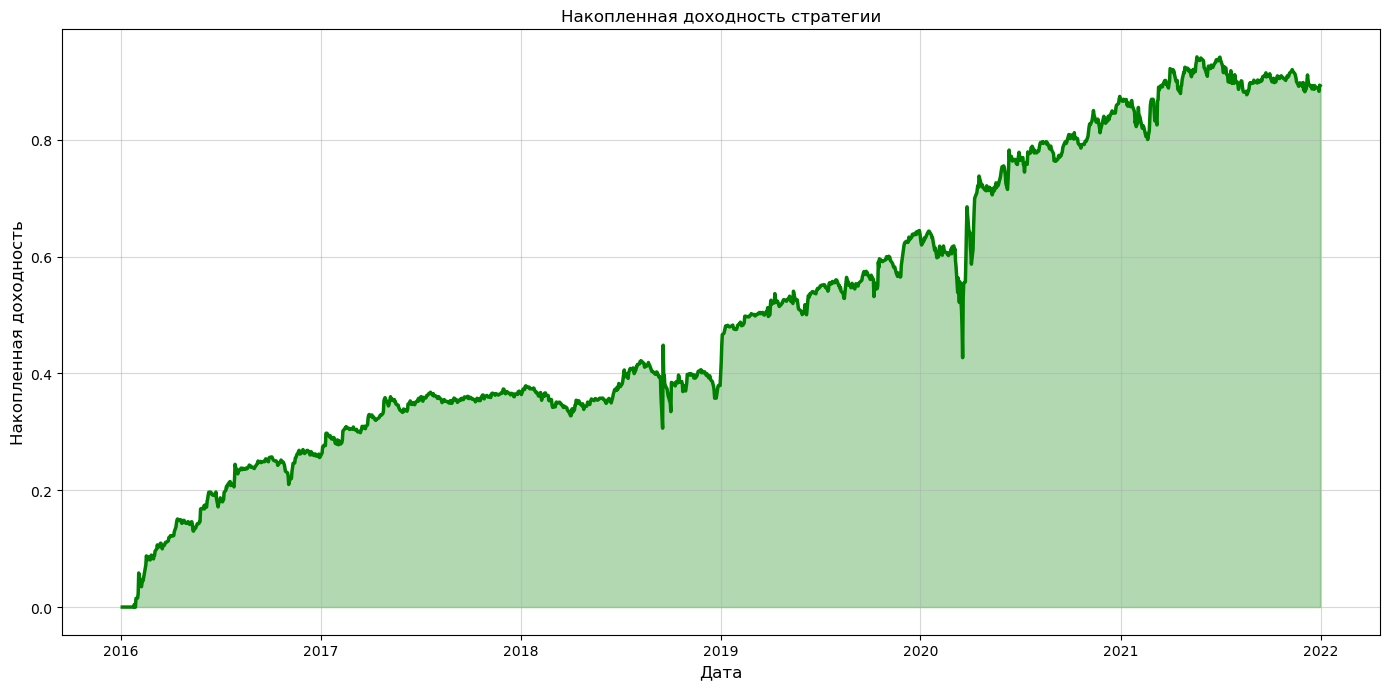

Максимальная просадка: 0.2177
Итоговая доходность: 0.8925

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 3.0425   | 0.2620     | 0.2564       | 0.0472    
2017   | 1.9742   | 0.2559     | 0.1131       | 0.0269    
2018   | 0.0518   | 0.2630     | 0.0097       | 0.1153    
2019   | 2.2807   | 0.2646     | 0.2602       | 0.0433    
2020   | 1.0999   | 0.2860     | 0.2299       | 0.2166    
2021   | 0.2003   | 0.2717     | 0.0232       | 0.0691    


In [5]:
#alpha1
prices_df = pd.read_parquet('close.parquet')

alpha1 = AlphaStrategy()

#
alpha1.create(prices_df.shift(14)/prices_df.shift(1), prices_df)

alpha1.manipulate(
    decay_alpha(2),
    neutralization,
    normalization
)

results1 = alpha1.backtest()

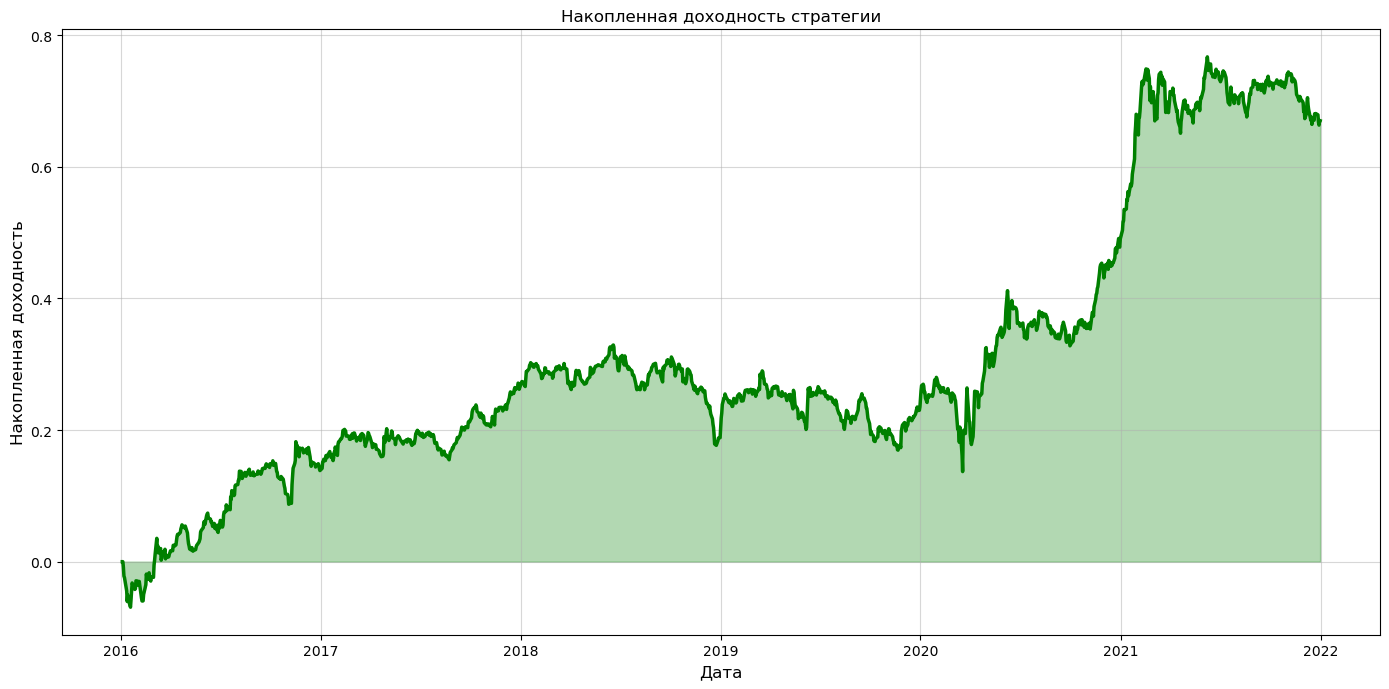

Максимальная просадка: 0.1923
Итоговая доходность: 0.6700

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 1.2570   | 0.3356     | 0.1384       | 0.0692    
2017   | 1.5828   | 0.3301     | 0.1235       | 0.0472    
2018   | -0.8301  | 0.3450     | -0.0737      | 0.1525    
2019   | 0.4112   | 0.3278     | 0.0470       | 0.1204    
2020   | 1.4892   | 0.3446     | 0.2552       | 0.1431    
2021   | 1.1062   | 0.3150     | 0.1795       | 0.1037    


In [6]:
#alpha2
close_df = pd.read_parquet('close.parquet')
high_df = pd.read_parquet('high.parquet')
low_df = pd.read_parquet('low.parquet')

alpha2 = AlphaStrategy()

alpha2.create((high_df - low_df).shift(1)/close_df.shift(1), close_df)

alpha2.manipulate(
    decay_alpha(3),
    neutralization,
    normalization
)

results2 = alpha2.backtest()


In [50]:
print("alpha1.final_alpha.shape:", alpha1.final_alpha.shape)
print("alpha2.final_alpha.shape:", alpha2.final_alpha.shape)
print("alpha1.final_alpha.index[0], ...[-1]:", alpha1.final_alpha.index[0], alpha1.final_alpha.index[-1])
print("alpha2.final_alpha.index[0], ...[-1]:", alpha2.final_alpha.index[0], alpha2.final_alpha.index[-1])
print("alpha1 columns:", alpha1.final_alpha.columns[:5], "... total:", len(alpha1.final_alpha.columns))
print("alpha2 columns:", alpha2.final_alpha.columns[:5], "... total:", len(alpha2.final_alpha.columns))

alpha1.final_alpha.shape: (1497, 1300)
alpha2.final_alpha.shape: (1510, 1300)
alpha1.final_alpha.index[0], ...[-1]: 2016-01-25 00:00:00 2021-12-31 00:00:00
alpha2.final_alpha.index[0], ...[-1]: 2016-01-05 00:00:00 2021-12-31 00:00:00
alpha1 columns: Index(['A', 'AACG', 'AAMI', 'AAOI', 'AAPL'], dtype='object') ... total: 1300
alpha2 columns: Index(['A', 'AACG', 'AAMI', 'AAOI', 'AAPL'], dtype='object') ... total: 1300


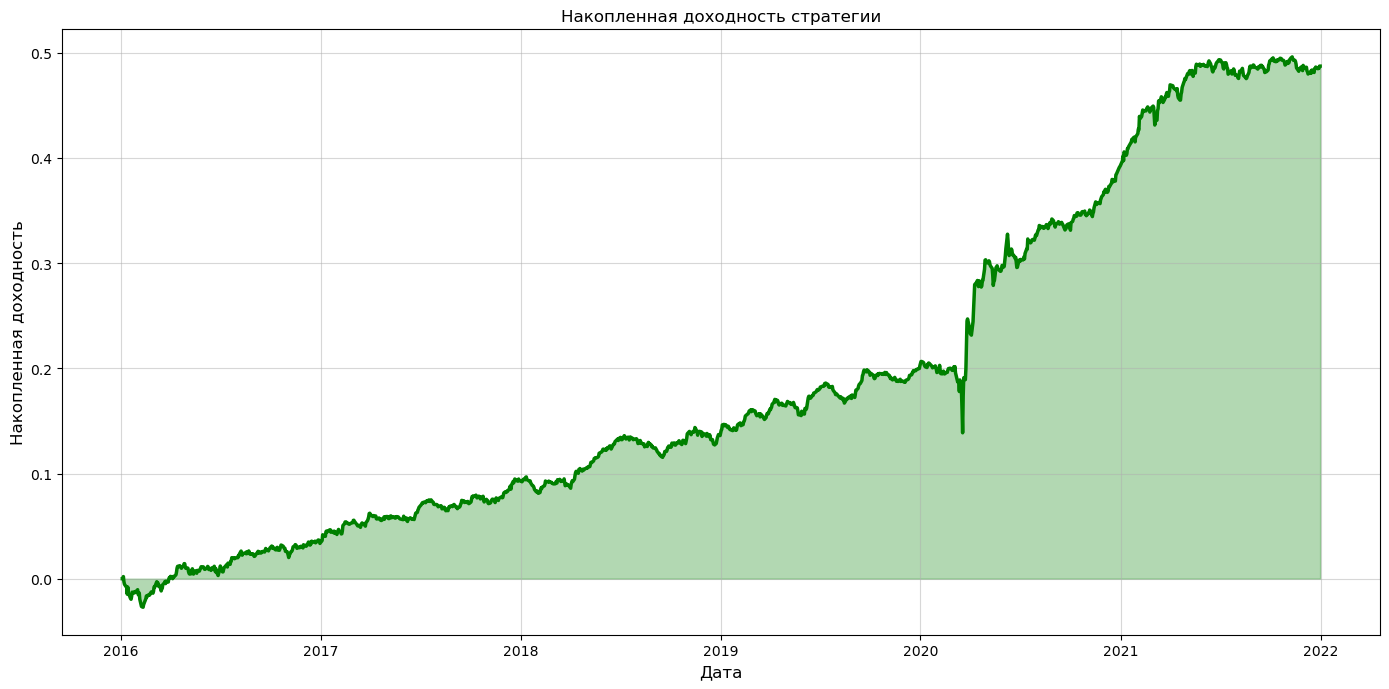

Максимальная просадка: 0.0678
Итоговая доходность: 0.4873

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 1.0469   | 0.6904     | 0.0336       | 0.0291    
2017   | 2.5400   | 0.7123     | 0.0596       | 0.0104    
2018   | 1.7211   | 0.7299     | 0.0430       | 0.0206    
2019   | 2.4485   | 0.7249     | 0.0666       | 0.0190    
2020   | 2.3548   | 0.7365     | 0.1899       | 0.0678    
2021   | 2.2321   | 0.7441     | 0.0948       | 0.0180    


In [7]:
#alpha3: -(close_df - low_df).shift(1)/(high_df - low_df)
close_df = pd.read_parquet('close.parquet')
high_df = pd.read_parquet('high.parquet')
low_df = pd.read_parquet('low.parquet')
open_df = pd.read_parquet('open.parquet')
alpha3 = AlphaStrategy()
alpha3.create(-(close_df - low_df).shift(1)/(high_df - low_df).shift(1), close_df)

alpha3.manipulate(
    #cut_outliers(10),
    #cut_middle(100),
    rank(),
    decay_alpha(7),
    
    neutralization,
    normalization
)

results3 = alpha3.backtest()


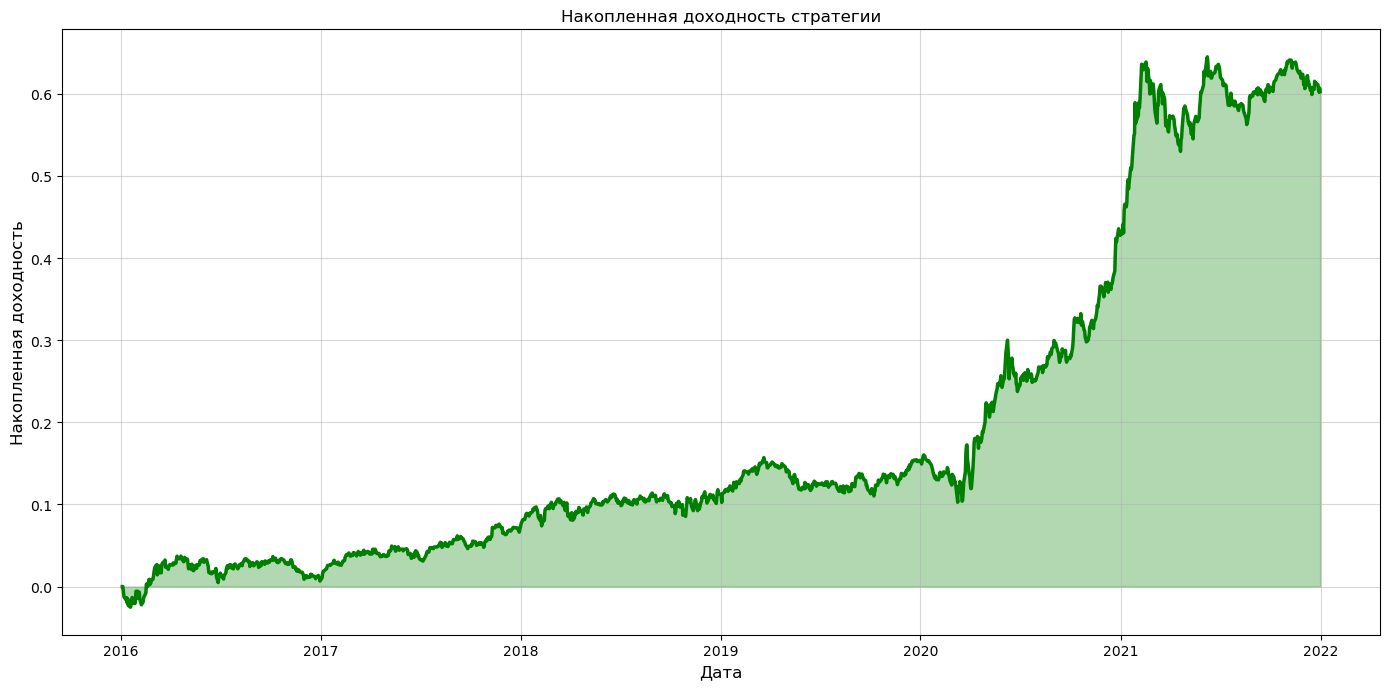

Максимальная просадка: 0.1089
Итоговая доходность: 0.6025

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 0.1221   | 0.1581     | 0.0067       | 0.0323    
2017   | 1.6924   | 0.1738     | 0.0595       | 0.0184    
2018   | 0.7708   | 0.1601     | 0.0464       | 0.0285    
2019   | 0.8209   | 0.1633     | 0.0410       | 0.0468    
2020   | 2.2961   | 0.1536     | 0.2742       | 0.0624    
2021   | 1.2611   | 0.1606     | 0.1747       | 0.1089    


In [27]:
#alpha4
close_df = pd.read_parquet('close.parquet')
high_df = pd.read_parquet('high.parquet')
low_df = pd.read_parquet('low.parquet')
open_df = pd.read_parquet('open.parquet')
volume_df = pd.read_parquet('volume.parquet')
alpha4 = AlphaStrategy()
alpha4.create(((high_df - low_df)*volume_df).shift(1)/(close_df).shift(1), close_df)

alpha4.manipulate(
    cut_outliers(5),
    decay_alpha(7),
    
    neutralization,
    normalization
)

results4 = alpha4.backtest()

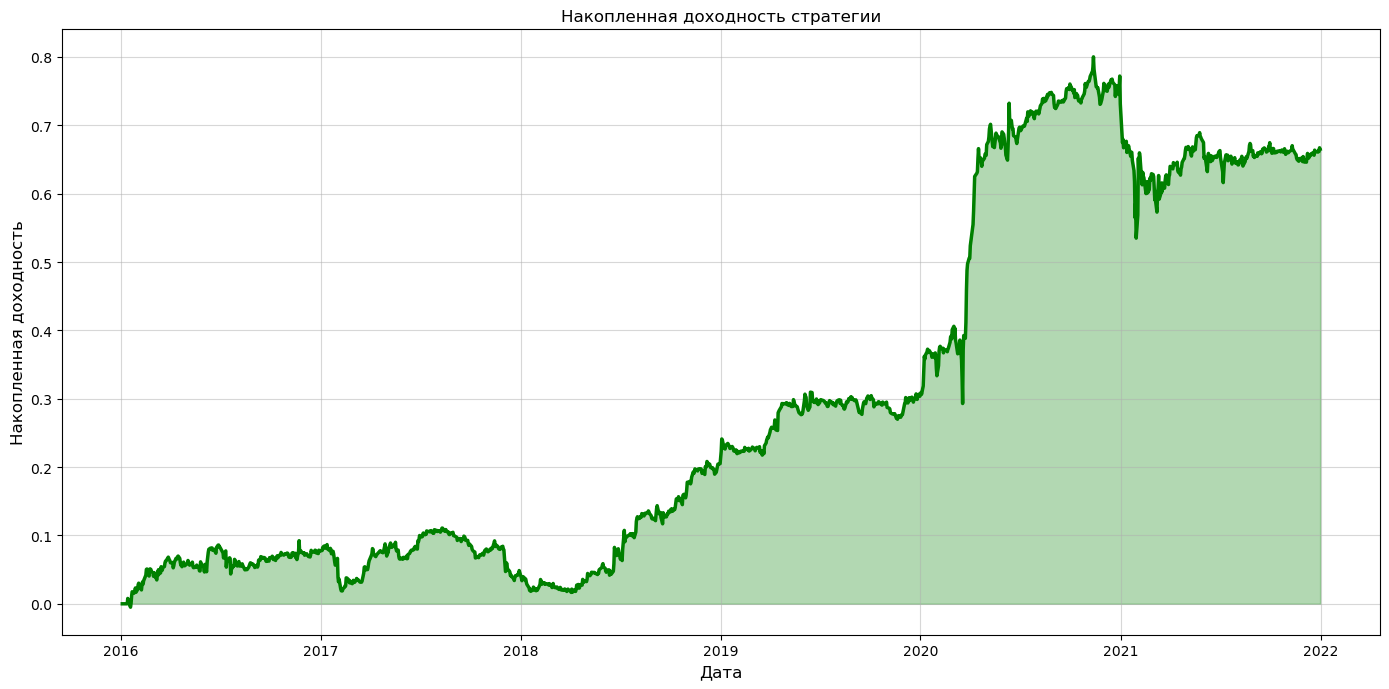

Максимальная просадка: 0.2652
Итоговая доходность: 0.6649

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 1.0015   | 0.3439     | 0.0771       | 0.0423    
2017   | -0.3949  | 0.3357     | -0.0284      | 0.0768    
2018   | 2.0331   | 0.3500     | 0.1563       | 0.0320    
2019   | 1.3176   | 0.3534     | 0.0987       | 0.0396    
2020   | 2.3290   | 0.3836     | 0.4275       | 0.1130    
2021   | -0.3610  | 0.3646     | -0.0663      | 0.1962    


In [9]:
#alpha5
close_df = pd.read_parquet('close.parquet')
high_df = pd.read_parquet('high.parquet')
low_df = pd.read_parquet('low.parquet')
open_df = pd.read_parquet('open.parquet')
alpha5 = AlphaStrategy()

alpha5.create(-(high_df + low_df).shift(1)/(open_df + close_df).shift(7), close_df)

alpha5.manipulate(
    decay_alpha(2),
    neutralization,
    normalization
)

results5 = alpha5.backtest()

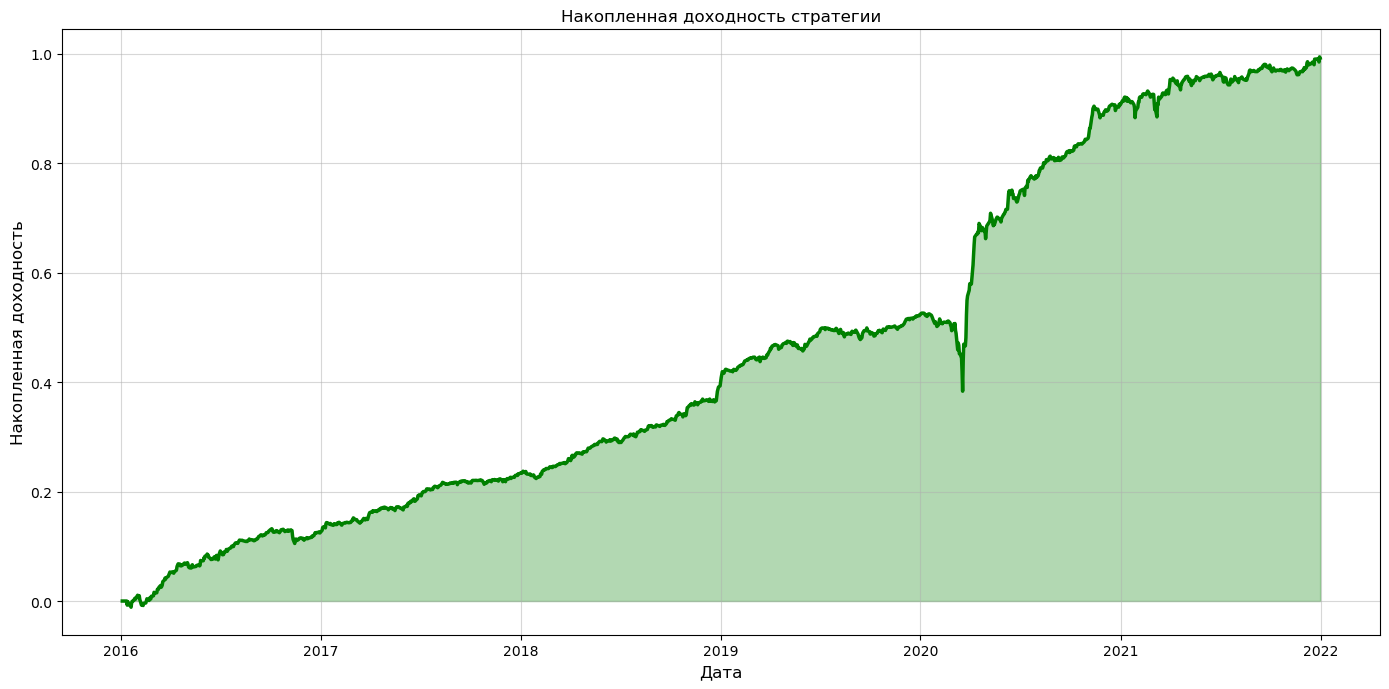

Максимальная просадка: 0.1428
Итоговая доходность: 0.9918

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 2.8833   | 0.5387     | 0.1244       | 0.0270    
2017   | 3.7446   | 0.5380     | 0.1083       | 0.0096    
2018   | 4.6307   | 0.5456     | 0.1605       | 0.0134    
2019   | 3.1968   | 0.5308     | 0.1305       | 0.0213    
2020   | 2.9196   | 0.5579     | 0.3828       | 0.1428    
2021   | 1.2142   | 0.5410     | 0.0852       | 0.0474    


In [10]:
#alpha6
prices_df = pd.read_parquet('close.parquet')

def calculate_rsi(data, window=7):
    rsi_df = pd.DataFrame(index=data.index, columns=data.columns)
    
    for column in data.columns:
        delta = data[column].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        rsi_df[column] = rsi
    
    return rsi_df

rsi_df = calculate_rsi(prices_df, window=7)

alpha6 = AlphaStrategy()
alpha6.create(
    lambda prices: -rsi_df,
    prices_df
)

alpha6.manipulate(
    truncate(0.01),
    neutralization,
    normalization
)

results6 = alpha6.backtest()

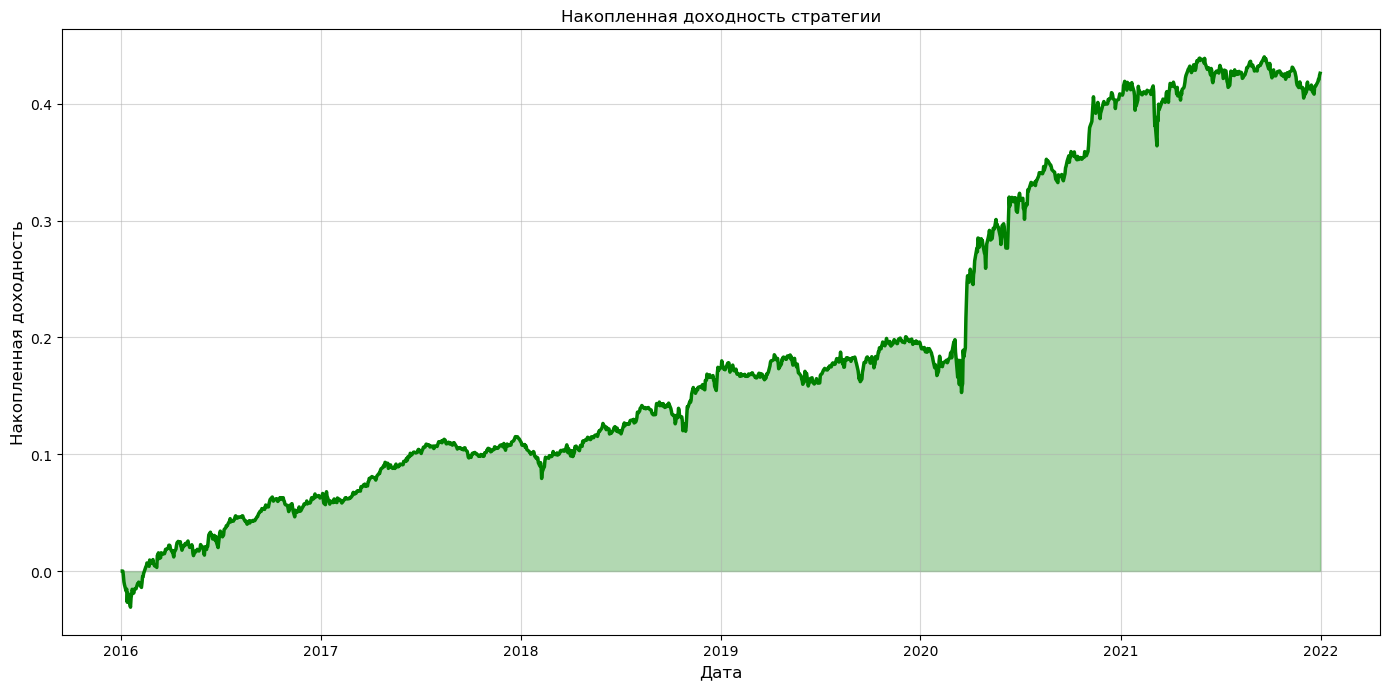

Максимальная просадка: 0.0552
Итоговая доходность: 0.4262

ГОДОВАЯ СТАТИСТИКА
------------------------------------------------------------
Год    | Шарп     | Оборот     | Доходность   | Просадка  
------------------------------------------------------------
2016   | 1.5033   | 0.1935     | 0.0625       | 0.0309    
2017   | 2.0350   | 0.1856     | 0.0507       | 0.0160    
2018   | 1.3874   | 0.1950     | 0.0610       | 0.0339    
2019   | 0.5345   | 0.1849     | 0.0215       | 0.0267    
2020   | 2.2098   | 0.1913     | 0.2127       | 0.0452    
2021   | 0.2697   | 0.1964     | 0.0179       | 0.0552    


In [23]:
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):

    macd_histogram_df = pd.DataFrame(index=data.index, columns=data.columns)
    
    for column in data.columns:
        
        ema_fast = data[column].ewm(span=fast_period, adjust=False).mean()
        ema_slow = data[column].ewm(span=slow_period, adjust=False).mean()
        
        macd_line = ema_fast - ema_slow
        
        signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
        
        macd_histogram = macd_line - signal_line
        
        macd_histogram_df[column] = macd_histogram
    
    return macd_histogram_df

macd_histogram = calculate_macd(prices_df, fast_period=12, slow_period=26, signal_period=9)

alpha7 = AlphaStrategy()
alpha7.create(
    lambda prices: -macd_histogram,
    prices_df
)

alpha7.manipulate(
    rank(),
    decay_alpha(2),
    neutralization,
    normalization
)

results7 = alpha7.backtest()

In [19]:
strategies = {
    'alpha_1': alpha1,
    'alpha_2': alpha2,
    'alpha_3': alpha3,
    'alpha_4': alpha4,
    'alpha_5': alpha5,
    'alpha_6': alpha6,
    'alpha_7': alpha7
}

corr_df = correlation_matrix(strategies)
print("Матрица корреляций альф:")
print(corr_df.round(4))

Матрица корреляций альф:
         alpha_1  alpha_2  alpha_3  alpha_4  alpha_5  alpha_6  alpha_7
alpha_1   1.0000   0.1020   0.3160   0.0177  -0.1656   0.3215   0.3540
alpha_2   0.1020   1.0000   0.1135   0.1320  -0.1810   0.0784  -0.0234
alpha_3   0.3160   0.1135   1.0000   0.0216  -0.0182   0.2789   0.2699
alpha_4   0.0177   0.1320   0.0216   1.0000  -0.0424   0.0101  -0.0104
alpha_5  -0.1656  -0.1810  -0.0182  -0.0424   1.0000   0.4947   0.2929
alpha_6   0.3215   0.0784   0.2789   0.0101   0.4947   1.0000   0.4756
alpha_7   0.3540  -0.0234   0.2699  -0.0104   0.2929   0.4756   1.0000
